<a href="https://colab.research.google.com/github/SammyGbabs/Maize_Classification-Model/blob/main/Maize_classification_Model_(Using_Pre_trained_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset


Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 95% 153M/161M [00:00<00:00, 173MB/s]
100% 161M/161M [00:00<00:00, 169MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/corn-or-maize-leaf-disease-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [7]:
#Defining the directory path for the dataset
path = '/content/data'

#Getting and loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [8]:
#Getting the class names
classes = dataset.class_names
classes

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [9]:
#The length of the dataset
len(dataset)

131

In [10]:
#A batch of 32 and each image has size of 256 * 256 pixels
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 2 1 3 3 0 1 0 1 3 3 1 0 2 2 3 3 3 3 0 1 1 1 1 3 1 1 0 3 0 3]


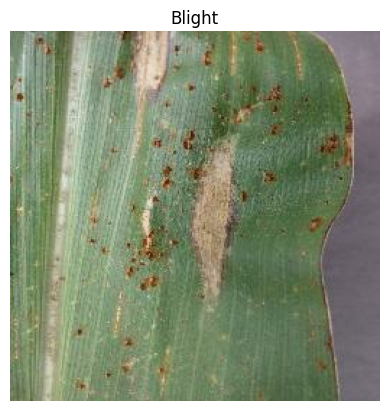

In [11]:
#Viewing one of the images
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(classes[label_batch[0]])
  plt.axis("off")

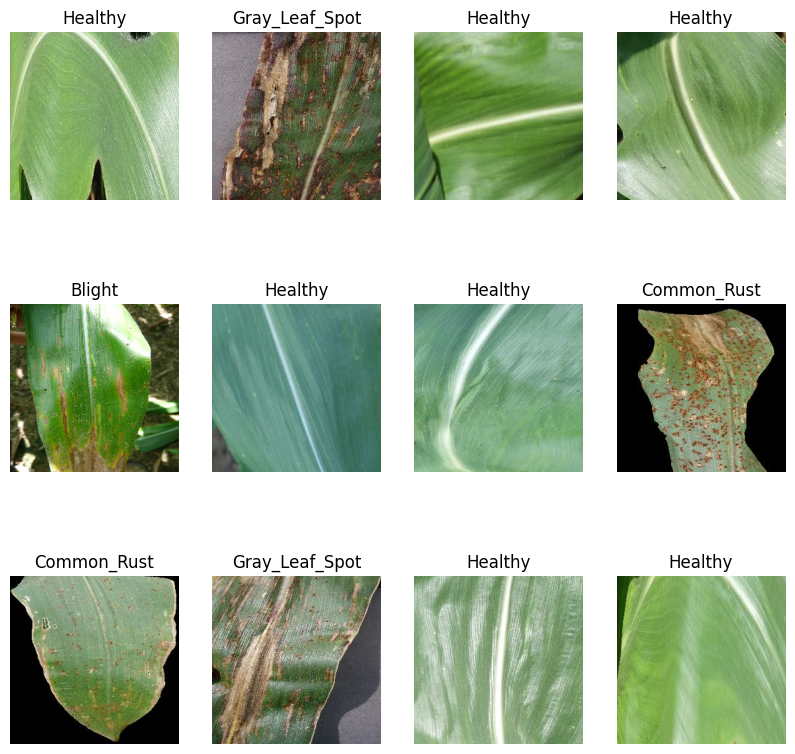

In [12]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")

In [13]:
#Getting the train size for the dataset
train_size = 0.7
len(dataset) * train_size

91.69999999999999

In [14]:
#Defining a function to split the dataset in tf
def splitting_dataset_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = splitting_dataset_tf(dataset)


In [16]:
len(train_ds)

91

In [17]:
len(val_ds)

19

In [18]:
len(test_ds)

21

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
#Scaling the dataset
scaling = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Method 2: Data augmentation for training dataset
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## **Using Pre-Trained Model**

In [22]:
#Importing the pre-trained models
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

**1) VGG16**

In [27]:
# Pre-trained model, VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# Selected layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# model
model = Model(inputs=base_model.input, outputs=predictions)

In [29]:
# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [30]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit(
    train_ds,
    epochs = 2,
    validation_data = val_ds,
    verbose = 1,
)

Epoch 1/2
91/91 ━━━━━━━━━━━━━━━━━━━━ 2831s 31s/step - accuracy: 0.7495 - loss: 1.5864 - val_accuracy: 0.9243 - val_loss: 0.2860
Epoch 2/2
91/91 ━━━━━━━━━━━━━━━━━━━━ 2823s 31s/step - accuracy: 0.9034 - loss: 0.3279 - val_accuracy: 0.9013 - val_loss: 0.2619


**2) InceptionV3**

In [32]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Selected layers for fine-tuning
x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# model
model_inception = Model(inputs=base_model_inception.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model_inception.layers:
    layer.trainable = False

# Compiling the model
model_inception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_inception.fit(
    train_ds,
    epochs = 4,
    validation_data = val_ds,
    verbose = 1,
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/4
91/91 ━━━━━━━━━━━━━━━━━━━━ 594s 6s/step - accuracy: 0.5280 - loss: 25.9995 - val_accuracy: 0.7286 - val_loss: 1.0824
Epoch 2/4
91/91 ━━━━━━━━━━━━━━━━━━━━ 618s 6s/step - accuracy: 0.6898 - loss: 0.9206 - val_accuracy: 0.7237 - val_loss: 0.6808
Epoch 3/4
91/91 ━━━━━━━━━━━━━━━━━━━━ 583s 6s/step - accuracy: 0.7050 - loss: 0.7212 - val_accuracy: 0.7615 - val_loss: 0.6047
Epoch 4/4
91/91 ━━━━━━━━━━━━━━━━━━━━ 583s 6s/step - accuracy: 0.7503 - loss: 0.6495 - val_accuracy: 0.7401 - val_loss: 0.5870


**3) Desnet201**

In [23]:
base_model_densenet = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Selected layers for fine-tuning
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# model
model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model_densenet.layers:
    layer.trainable = False

# Compiling the model
model_densenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_densenet.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds,
    verbose = 1,
)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1412s 15s/step - accuracy: 0.7110 - loss: 1.6081 - val_accuracy: 0.8684 - val_loss: 0.4955
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1309s 14s/step - accuracy: 0.8770 - loss: 0.4248 - val_accuracy: 0.8783 - val_loss: 0.3288
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1342s 14s/step - accuracy: 0.8962 - loss: 0.2564 - val_accuracy: 0.8947 - val_loss: 0.3283
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1289s 14s/step - accuracy: 0.8989 - loss: 0.2724 - val_accuracy: 0.9046 - val_loss: 0.2784
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1285s 14s/step - accuracy: 0.9099 - loss: 0.2353 - val_accuracy: 0.9178 - val_loss: 0.2758
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1279s 14s/step - accuracy: 0.9253 - loss: 0.2085 - val_accuracy: 0.9293 - val_loss: 0.2112
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1328s 15s/step - accuracy: 0.9201 - loss: 0.2095 - val_accuracy: 0.9260 - val_loss: 0.2139
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1326s 15

In [33]:
# Evaluating the VGG16
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy VGG16 Model: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 538s 26s/step - accuracy: 0.9194 - loss: 0.2742
Test Accuracy VGG16 Model: 0.9003, Test Loss: 0.3210


In [35]:
# Evaluating the InceptionV3
test_loss, test_accuracy = model_inception.evaluate(test_ds)
print(f"Test Accuracy InceptionV3 Model: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.7547 - loss: 0.5671
Test Accuracy InceptionV3 Model: 0.7426, Test Loss: 0.5936


In [34]:
# Evaluating the DenseNet201
test_loss, test_accuracy = model_densenet.evaluate(test_ds)
print(f"Test Accuracy DesnseNet201 Model: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 250s 12s/step - accuracy: 0.9572 - loss: 0.1397
Test Accuracy DesnseNet201 Model: 0.9643, Test Loss: 0.1200


**Performance Metrics for the three Pre-trained Model**

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

 - **VGG16**

In [37]:
# Prediction on test data using VGG16 model
test_preds = model.predict(test_ds)
test_preds = np.argmax(test_preds, axis=1)

true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# report for VGG16
print(classification_report(true_labels, test_preds, target_names=classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 536s 25s/step
                precision    recall  f1-score   support

        Blight       0.31      0.21      0.25       189
   Common_Rust       0.34      0.35      0.35       212
Gray_Leaf_Spot       0.16      0.26      0.20        88
       Healthy       0.34      0.34      0.34       183

      accuracy                           0.30       672
     macro avg       0.29      0.29      0.28       672
  weighted avg       0.31      0.30      0.30       672



 - **InceptionV3**

In [39]:
# Prediction on test data using InceptionV3 model
test_preds = model_inception.predict(test_ds)
test_preds = np.argmax(test_preds, axis=1)

true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# report for InceptionV3
print(classification_report(true_labels, test_preds, target_names=classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step
                precision    recall  f1-score   support

        Blight       0.32      0.43      0.37       189
   Common_Rust       0.30      0.30      0.30       212
Gray_Leaf_Spot       0.00      0.00      0.00        88
       Healthy       0.26      0.30      0.28       183

      accuracy                           0.30       672
     macro avg       0.22      0.26      0.24       672
  weighted avg       0.26      0.30      0.27       672



 - **DenseNet201**

In [26]:
# Prediction on test data using DenseNet201 model
test_preds = model_densenet.predict(test_ds)
test_preds = np.argmax(test_preds, axis=1)

true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# Report for DenseNet201
print(classification_report(true_labels, test_preds, target_names=classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 266s 12s/step
                precision    recall  f1-score   support

        Blight       0.26      0.27      0.26       189
   Common_Rust       0.30      0.30      0.30       212
Gray_Leaf_Spot       0.25      0.24      0.25        88
       Healthy       0.24      0.23      0.24       183

      accuracy                           0.26       672
     macro avg       0.26      0.26      0.26       672
  weighted avg       0.27      0.26      0.26       672



**After experimenting with three pre-trained models—VGG16, InceptionV3, and DenseNet201, I observed that DenseNet201 outperformed the other models. As a result, I have decided to use DenseNet201 for this project.:**

First image to predict:
Actual label on dataset: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted label by model: Common_Rust


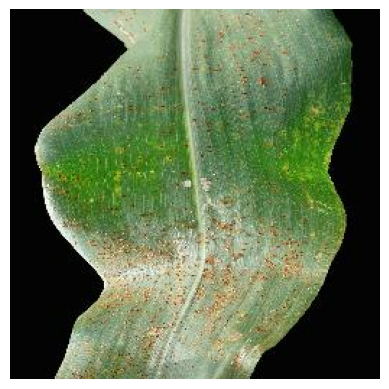

In [38]:
#Making a prediction
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  img_1 = images_batch[0].numpy().astype('uint8')
  img1_label = labels_batch[0].numpy()

  print('First image to predict:')
  plt.imshow(img_1)
  print('Actual label on dataset:', classes[img1_label])

  batch_prediction = model_densenet.predict(images_batch)
  print('Predicted label by model:', classes[np.argmax(batch_prediction[0])])
  plt.axis("off")

In [42]:
#Saving ther model using pickle
import pickle

with open('model_densenet.pkl', 'wb') as f:
    pickle.dump(model_densenet, f)

# Save the model to an HDF5 file
model_densenet.save('model_densenet.h5')

# Save the model with a .keras extension
model_densenet.save('model_densenet.keras')

#Saving the model using joblib
import joblib

joblib.dump(model_densenet, 'model_densenet.joblib')